<h1>Konfiguracja</h1>

<h3>Instalacja bibliotek</h3>

In [ ]:
!pip install moviepy
!pip install mediapipe
!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [ ]:
!pip uninstall numpy
!pip install numpy

<h3>Funkcje pomocnicze</h3>

Importowanie i konfiguracja

In [2]:
import numpy as np
import math
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

Filtrowanie punktów kluczowych pozy ciała

In [3]:
def filter_pose_landmarks(pose):
    indexes_to_remove = [23,24,25,26,27,28,29,30,31,32]
    filtered = np.delete(pose,indexes_to_remove)
    return filtered

Ekstrakcja znormalizowanych punktów kluczowych

In [4]:
def extract_keypoints_with_normalization(results):
    smallestX = 1
    biggestX = 0
    smallestY = 1
    biggestY = 0
    smallestZ = 1
    biggestZ = 0

    pose = np.array([[res.x, res.y, res.z] for res in filter_pose_landmarks(results.pose_landmarks.landmark)] if results.pose_landmarks else [[0,0,0] for i in range(23)]) 
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark] if results.left_hand_landmarks else [[0,0,0] for i in range(21)]) 
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark] if results.right_hand_landmarks else [[0,0,0] for i in range(21)]) 
    concatenated = np.concatenate([pose, lh, rh])
    for landmark in concatenated:
        newX = landmark[0]
        newY = landmark[1]
        newZ = landmark[2]
        if(smallestX>newX):
            smallestX = newX 
        if(biggestX<newX):
            biggestX = newX 
        if(smallestY>newY):
            smallestY = newY 
        if(biggestY<newY):
            biggestY = newY 
        if(smallestZ>newZ):
            smallestZ = newZ 
        if(biggestZ<newZ):
            biggestZ = newZ 
        
    normalizedLandmarks = []
    for landmark in concatenated:
        x_norm = (landmark[0]-smallestX)/(biggestX-smallestX)
        y_norm = (landmark[1]-smallestY)/(biggestY-smallestY)
        z_norm = (landmark[2]-smallestZ)/(biggestZ-smallestZ)
        if math.isnan(x_norm):
            x_norm = 0.0
        if math.isnan(y_norm):
            y_norm = 0.0
        if math.isnan(z_norm):
            z_norm = 0.0
        normalizedLandmarks.append([x_norm,y_norm,z_norm])
    return np.array(normalizedLandmarks).flatten()

Detekcja punktów kluczowych

In [5]:
def mediapipe_video_detection(image,model):
    results = model.process(image)
    return image,results

Rysowanie rozpoznanych punktów kluczowych

In [6]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(70,70,200), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(70,70,70), thickness=1, circle_radius=1)
                             ) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(170,170,170), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(70,70,70), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(70,200,70), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(70,70,70), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(200,70,70), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(70,70,70), thickness=2, circle_radius=2)
                             ) 

<h1>Zbieranie nagrań</h1>

Importowanie

In [7]:
from moviepy.editor import *
import numpy as np
import cv2
import os

Stałe i zmienne

In [15]:

DATA_PATH = os.path.join('videos/PJM') 
ACTIONS_21 = ['dziękuję','proszę','przepraszam','od','jest','który','ja','gdzie','ty','imię','nazwisko','jeśli','ile','duży','mało','dobrze','źle','wiem','dom','mieszkać','kocham']
OLD_9_ACTIONS = ['dziękuję','gdzie','ja','jest','który','mam','od','proszę','przepraszam']
ALL_ACTIONS = ACTIONS_21

no_sequences = 30
sequence_length = 45

Tworzenie folderów dla znaków dynamicznych

In [16]:
for action in ALL_ACTIONS: 
    try: 
        os.makedirs(os.path.join(DATA_PATH,'fps30', action))
        os.makedirs(os.path.join(DATA_PATH,'fps15', action))
    except:
        pass

Zbieranie sekwencji

In [21]:
actions = np.array(['jest'])

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FPS, 30)
cv2.waitKey(3000)
for action in actions:
    for sequence in range(1,no_sequences+1):
        recorded_frames = []
        for frame_num in range(sequence_length+1):
            ret, image = cap.read()
            
            if frame_num == 0: 
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'COLLECT IN: 3', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (35, 184, 75), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(1000)
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'COLLECT IN: 2', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (35, 184, 75), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(1000)
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'COLLECT IN: 1', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (35, 184, 75), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(1000)
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'GET READY', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (61, 223, 235), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(500)
            else: 
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'COLLECTING NOW', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (25, 29, 250), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                recorded_frames.append(image)  
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        save_path_30 = os.path.join(DATA_PATH,'fps30', action,str(sequence)+'.mp4')
        save_path_15 = os.path.join(DATA_PATH,'fps15', action,str(sequence)+'.mp4')
        clip30 = ImageSequenceClip(recorded_frames, fps=30)
        clip30.write_videofile(save_path_30, fps=30,codec="libx264")
        clip15 = ImageSequenceClip(recorded_frames, fps=30)
        clip15.write_videofile(save_path_15, fps=15,codec="libx264")
        
                    
cap.release()
cv2.destroyAllWindows()

<h1>Konwersja video na mediapipe keypoints<h1>

Stałe i zmienne

In [17]:
KEYPOINTS_DATA_PATH = "dynamicKeypoints/PJM"
FRAMESNO='fps15'

Tworzenie folderów dla punkty kluczowe

In [18]:
for action in ALL_ACTIONS: 
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(KEYPOINTS_DATA_PATH,'fps15', action, str(sequence)))
            os.makedirs(os.path.join(KEYPOINTS_DATA_PATH,'fps30', action, str(sequence)))
        except:
            pass

Konwersja nagrań na punkty kluczowe

In [25]:

from moviepy.editor import *

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in ALL_ACTIONS:
        for sequence in range(1,no_sequences+1):
            clip = VideoFileClip(os.path.join(DATA_PATH,FRAMESNO,action,str(sequence)+".mp4"))
            frames = clip.iter_frames()
            clip_fps = clip.fps
            counter = 0
            for frame in frames:
                image, results = mediapipe_video_detection(frame, holistic)
                keypoints = extract_keypoints_with_normalization(results)
                npy_path = os.path.join(KEYPOINTS_DATA_PATH,FRAMESNO,action,str(sequence),str(counter))
                np.save(npy_path, keypoints)
                counter += 1
     

<h1>Szkolenie modelu</h1>

Importowanie

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN
from tensorflow.keras.callbacks import TensorBoard,Callback

Stałe i zmienne

In [27]:
SEQUENCELENGTH_15FPS = 23

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

label_map = {label:num for num, label in enumerate(ALL_ACTIONS)}
print(label_map)

{'dziękuję': 0, 'proszę': 1, 'przepraszam': 2, 'od': 3, 'jest': 4, 'który': 5, 'ja': 6, 'gdzie': 7, 'ty': 8, 'imię': 9, 'nazwisko': 10, 'jeśli': 11, 'ile': 12, 'duży': 13, 'mało': 14, 'dobrze': 15, 'źle': 16, 'wiem': 17, 'dom': 18, 'mieszkać': 19, 'kocham': 20}


Wczytanie danych z tablic

In [28]:
sequences, labels = [], []
for action in ALL_ACTIONS:
    for sequence in np.array(os.listdir(os.path.join(KEYPOINTS_DATA_PATH,FRAMESNO, action))).astype(int):
        window = []
        for frame_num in range(SEQUENCELENGTH_15FPS):
            res = np.load(os.path.join(KEYPOINTS_DATA_PATH,FRAMESNO, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

Przygotowanie i podział na zbiory 

In [31]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X, y = shuffle(X, y, random_state=15)
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y,stratify=y,test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test,stratify=y_val_test,test_size=0.5)

print("x train shape: ")
print(X_train.shape)
print("x val shape: ")
print(X_val.shape)
print("x test shape: ")
print(X_test.shape)


print("x shape: ")
print(X.shape)
print("y shape: ")
print(y.shape)
print("x_test shape: ")
print(X_test.shape)
print("y_test shape: ")
print(y_test.shape)

x train shape: 
(504, 23, 195)
x val shape: 
(63, 23, 195)
x test shape: 
(63, 23, 195)
x shape: 
(630, 23, 195)
y shape: 
(630, 21)
x_test shape: 
(63, 23, 195)
y_test shape: 
(63, 21)


<h3>Inicjalizacja i szkolenie modelu</h3>

Szkolenie LSTM

In [81]:
model2 = Sequential()
model2.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(23,195)))
model2.add(LSTM(64, return_sequences=False, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(np.array(ALL_ACTIONS).shape[0], activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
fit_history = model2.fit(X_train, y_train, epochs=300, callbacks=[tb_callback],validation_data=(X_val,y_val),verbose=0)
model2.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 23, 64)            66560     
                                                                 
 lstm_79 (LSTM)              (None, 64)                33024     
                                                                 
 dense_129 (Dense)           (None, 64)                4160      
                                                                 
 dense_130 (Dense)           (None, 64)                4160      
                                                                 
 dense_131 (Dense)           (None, 21)                1365      
                                                                 
Total params: 109,269
Trainable params: 109,269
Non-trainable params: 0
_________________________________________________________________


Szkolenie RNN

In [83]:
model2 = Sequential()
model2.add(SimpleRNN(64, return_sequences=True, activation='relu', input_shape=(23,195)))
model2.add(SimpleRNN(64, return_sequences=False, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(np.array(ALL_ACTIONS).shape[0], activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model2.fit(X_train, y_train, epochs=300, callbacks=[tb_callback],validation_data=(X_val,y_val),verbose=0)
model2.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 23, 64)            16640     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_135 (Dense)           (None, 64)                4160      
                                                                 
 dense_136 (Dense)           (None, 64)                4160      
                                                                 
 dense_137 (Dense)           (None, 21)                1365      
                                                                 
Total params: 34,581
Trainable params: 34,581
Non-trainable params: 0
_________________________________________________________________


Szkolenie GRU

In [82]:
model2 = Sequential()
model2.add(GRU(128, return_sequences=True, activation='relu', input_shape=(23,195)))
model2.add(GRU(128, return_sequences=False, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(np.array(ALL_ACTIONS).shape[0], activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model2.fit(X_train, y_train, epochs=350, callbacks=[tb_callback],validation_data=(X_val,y_val),verbose=0)
model2.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 23, 128)           124800    
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dense_132 (Dense)           (None, 64)                8256      
                                                                 
 dense_133 (Dense)           (None, 64)                4160      
                                                                 
 dense_134 (Dense)           (None, 21)                1365      
                                                                 
Total params: 237,653
Trainable params: 237,653
Non-trainable params: 0
_________________________________________________________________


Zapisanie modelu i prezentacja podsumowania

In [40]:
try: 
    os.makedirs('models')
except:
    pass

In [46]:
model2.save('models/PJM_21_full_dynamic_G64-G64-D64-D64_350.h5')
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 23, 128)           124800    
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 21)                1365      
                                                                 
Total params: 237,653
Trainable params: 237,653
Non-trainable params: 0
_________________________________________________________________


Wczytywanie modelu

In [42]:
from keras.models import load_model

In [47]:
model2 = load_model('models/PJM_21_full_dynamic_G64-G64-D64-D64_350.h5')

<h1> Dokładność i macierze błędów </h1>

Importowanie z bibliotek

In [44]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix

Obliczanie wyników dla zbioru testowego

In [48]:
yhat = model2.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
mtrx = multilabel_confusion_matrix(ytrue, yhat)
confusion_mtrx = confusion_matrix(ytrue,yhat)
accuracy = accuracy_score(ytrue, yhat)

Obliczanie wyników dla zbioru walidacyjnego


In [49]:
yhat_val = model2.predict(X_val)
ytrue_val = np.argmax(y_val, axis=1).tolist()
yhat_val = np.argmax(yhat_val, axis=1).tolist()
mtrx_val = multilabel_confusion_matrix(ytrue_val, yhat_val)
confusion_mtrx_val = confusion_matrix(ytrue_val,yhat_val)
accuracy_val = accuracy_score(ytrue_val, yhat_val)

Dokładność trenująca modelu matematycznego

In [50]:
print("Model accuracy: ")
print(accuracy)

Model accuracy: 
0.9365079365079365


Dokładność walidacyjna modelu matematycznego

In [51]:
print("VAL Model accuracy: ")
print(accuracy_val)

VAL Model accuracy: 
0.9206349206349206


Macierz błędów dla wszystkich znaków

<Axes: >

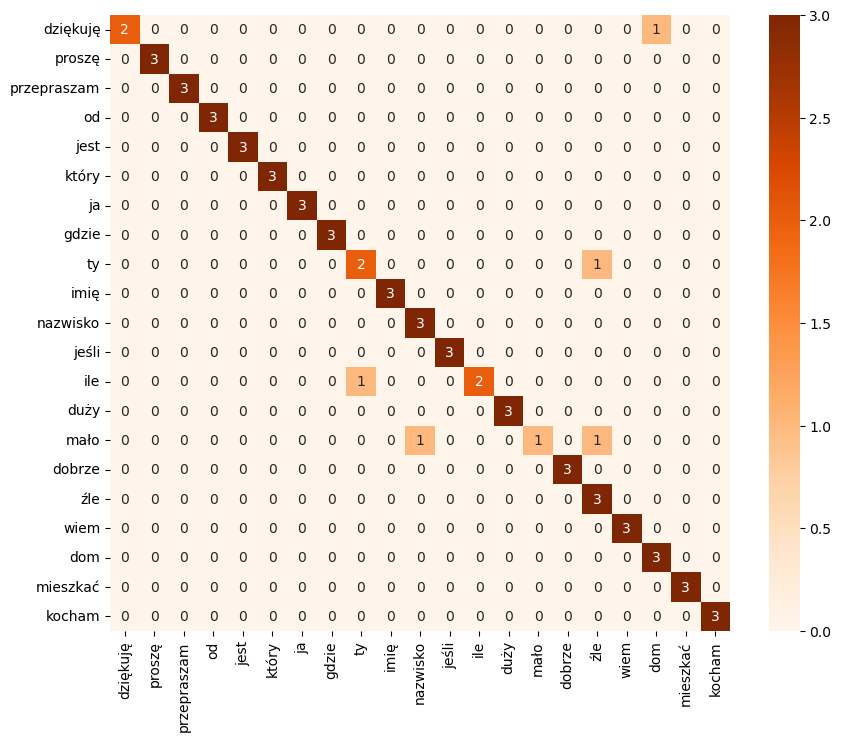

In [52]:
array_val = confusion_mtrx_val
df_cm_val = pd.DataFrame(array_val, index = [i for i in ALL_ACTIONS],
                  columns = [i for i in ALL_ACTIONS])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm_val, annot=True,cmap=plt.cm.Oranges)

<Axes: >

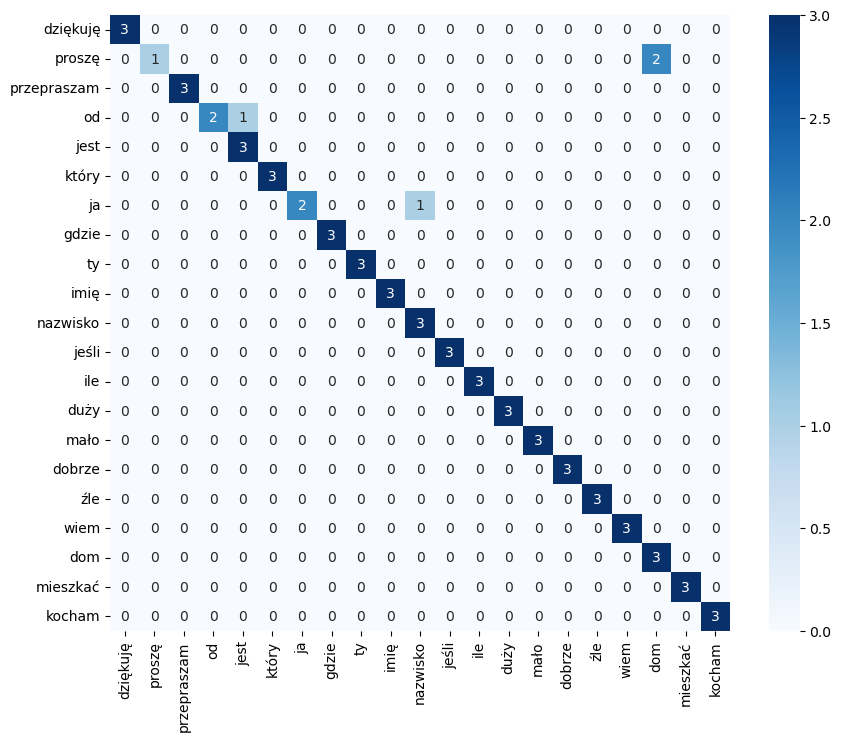

In [53]:
array = confusion_mtrx
df_cm = pd.DataFrame(array, index = [i for i in ALL_ACTIONS],
                  columns = [i for i in ALL_ACTIONS])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,cmap=plt.cm.Blues)

TABELA

<h1>Szkolenie zbiorowe</h1>

Importowanie


In [54]:
import numpy as np
import math
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN
from tensorflow.keras.callbacks import TensorBoard,Callback
import os

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.utils import shuffle

import pickle

Wczytanie wszystkich wartości dla szkoleń zbiorowych

In [55]:
DATA_PATH = os.path.join('videos/PJM') 
ACTIONS_21 = ['dziękuję','proszę','przepraszam','od','jest','który','ja','gdzie','ty','imię','nazwisko','jeśli','ile','duży','mało','dobrze','źle','wiem','dom','mieszkać','kocham']
OLD_9_ACTIONS = ['dziękuję','gdzie','ja','jest','który','mam','od','proszę','przepraszam']
ALL_ACTIONS = ACTIONS_21

no_sequences = 30
sequence_length = 45
KEYPOINTS_DATA_PATH = "dynamicKeypoints/PJM"
FRAMESNO='fps15'
SEQUENCELENGTH_15FPS = 23

Funkcja pomocnicza do zapisywania matryc 

In [56]:
def save_matrices(confusion_mtrx_train,confusion_mtrx_val,confusion_mtrx_test,save_name):
    df_cm_train = pd.DataFrame(confusion_mtrx_train, index = [i for i in ALL_ACTIONS],
                    columns = [i for i in ALL_ACTIONS])
    plt.figure(figsize = (10,8))
    sn.heatmap(df_cm_train, annot=True,cmap=plt.cm.Greens)
    plt.savefig(f"comparison/matrix/{save_name}_train.png") 
    plt.close()

    df_cm_val = pd.DataFrame(confusion_mtrx_val, index = [i for i in ALL_ACTIONS],
                    columns = [i for i in ALL_ACTIONS])
    plt.figure(figsize = (10,8))
    sn.heatmap(df_cm_val, annot=True,cmap=plt.cm.Oranges)
    plt.savefig(f"comparison/matrix/{save_name}_val.png") 
    plt.close()

    df_cm_test = pd.DataFrame(confusion_mtrx_test, index = [i for i in ALL_ACTIONS],
                    columns = [i for i in ALL_ACTIONS])
    plt.figure(figsize = (10,8))
    sn.heatmap(df_cm_test, annot=True,cmap=plt.cm.Blues)
    plt.savefig(f"comparison/matrix/{save_name}_test.png") 
    plt.close()

Zbiór funkcji do tworzenia przebiegów szkoleń

In [57]:
def val_plot(fit_history,save_name):
    fig,ax1 = plt.subplots(figsize = (10,8))
    ax2 = ax1.twinx()
    color_loss = '#D48002'
    color_accuracy = '#0072BD'
    ax1.plot(fit_history.history['val_loss'], color = color_loss)
    ax1.tick_params(axis='y', labelcolor=color_loss)
    ax1.set_ylabel('loss', color=color_loss)
    ax1.set_xlabel('epochs')
    ax2.plot(fit_history.history['val_categorical_accuracy'], color = color_accuracy)
    ax2.tick_params(axis='y', labelcolor=color_accuracy)
    ax2.set_ylabel('accuracy', color=color_accuracy)
    fig.savefig(f"comparison/plots/{save_name}_val.png")
    plt.close(fig) 

def train_plot(fit_history,save_name):
    fig,ax1 = plt.subplots(figsize = (10,8))
    ax2 = ax1.twinx()
    color_loss = '#D48002'
    color_accuracy = '#0072BD'
    ax1.plot(fit_history.history['loss'], color = color_loss)
    ax1.tick_params(axis='y', labelcolor=color_loss)
    ax1.set_ylabel('loss', color=color_loss)
    ax1.set_xlabel('epochs')
    ax2.plot(fit_history.history['categorical_accuracy'], color = color_accuracy)
    ax2.tick_params(axis='y', labelcolor=color_accuracy)
    ax2.set_ylabel('accuracy', color=color_accuracy)
    fig.savefig(f"comparison/plots/{save_name}_train.png")
    plt.close(fig) 
    
def loss_plot(fit_history,save_name):
    plt.figure(figsize = (15,12))
    plt.plot(fit_history.history['loss'])
    plt.plot(fit_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training','validation'],loc='upper left')
    plt.savefig(f"comparison/plots/{save_name}_loss.png") 
    plt.close()

def acc_plot(fit_history,save_name):
    plt.figure(figsize = (15,12))
    plt.plot(fit_history.history['categorical_accuracy'])
    plt.plot(fit_history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training','validation'],loc='upper left')
    plt.savefig(f"comparison/plots/{save_name}_acc.png") 
    plt.close()

Wczytanie wszystkich sekwencji ruchów zapisanych w formacie tablic

In [58]:
label_map = {label:num for num, label in enumerate(ALL_ACTIONS)}
print(label_map)
sequences, labels = [], []
for action in ALL_ACTIONS:
    for sequence in np.array(os.listdir(os.path.join(KEYPOINTS_DATA_PATH,FRAMESNO, action))).astype(int):
        window = []
        for frame_num in range(SEQUENCELENGTH_15FPS):
            res = np.load(os.path.join(KEYPOINTS_DATA_PATH,FRAMESNO, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

{'dziękuję': 0, 'proszę': 1, 'przepraszam': 2, 'od': 3, 'jest': 4, 'który': 5, 'ja': 6, 'gdzie': 7, 'ty': 8, 'imię': 9, 'nazwisko': 10, 'jeśli': 11, 'ile': 12, 'duży': 13, 'mało': 14, 'dobrze': 15, 'źle': 16, 'wiem': 17, 'dom': 18, 'mieszkać': 19, 'kocham': 20}


Klasa służąca do pomiaru czasu szkolenia


In [59]:
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

Funkcja pomocnicza określająca parametr return dla warstwy

In [60]:
def shouldReturn(layers,current_index,layer_type):
    if (current_index+1) <= (len(layers)-1): 
        if((layers[current_index+1])[0]==layer_type): 
            return True
        else:
            return False
    else:
        return False

Funkcja pomocnicza tworząca model z tekstu o zadanej strukturze

In [61]:
def createLayers(txt):
  layers = txt.split("-")
  creation_model = Sequential()
  for index, layer in enumerate(layers):
    layer_type = layer[0]
    layer_neurons = int(layer[1:])
    isFirstLayer = index == 0
    if isFirstLayer:
      if layer_type == 'L':
        shouldBeReturned = shouldReturn(layers,index,layer_type)
        creation_model.add(LSTM(layer_neurons, return_sequences=shouldBeReturned, activation='relu', input_shape=(23,195)))
      if layer_type =='G':
        shouldBeReturned = shouldReturn(layers,index,layer_type)
        creation_model.add(GRU(layer_neurons, return_sequences=shouldBeReturned, activation='relu', input_shape=(23,195)))
      if layer_type =='R':
        shouldBeReturned = shouldReturn(layers,index,layer_type)
        creation_model.add(SimpleRNN(layer_neurons, return_sequences=shouldBeReturned, activation='relu', input_shape=(23,195)))
      if layer_type =='D':
        creation_model.add(Dense(layer_neurons, activation='relu'))
    else:
      if layer_type == 'L':
        shouldBeReturned = shouldReturn(layers,index,layer_type)
        creation_model.add(LSTM(layer_neurons, return_sequences=shouldBeReturned, activation='relu'))
      if layer_type =='G':
        shouldBeReturned = shouldReturn(layers,index,layer_type)
        creation_model.add(GRU(layer_neurons, return_sequences=shouldBeReturned, activation='relu'))
      if layer_type =='R':
        shouldBeReturned = shouldReturn(layers,index,layer_type)
        creation_model.add(SimpleRNN(layer_neurons, return_sequences=shouldBeReturned, activation='relu'))
      if layer_type =='D':
        creation_model.add(Dense(layer_neurons, activation='relu'))
  creation_model.add(Dense(np.array(ALL_ACTIONS).shape[0], activation='softmax'))
  return creation_model

Funkcja szkoląca, zapisująca model, przebiegi szkolenia oraz wyniki dokładności

In [63]:
def train_model(model2,epochs,X_train,y_train,X_val,y_val,X_test,y_test,model_name,iteration,file):
    total_time_callback = TimingCallback()

    model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    fit_history = model2.fit(X_train, y_train, epochs=epochs, callbacks=[total_time_callback],validation_data=(X_val,y_val),verbose=0)

    model_save = f"a_{model_name}_{epochs}_{iteration}"
    model_save_name = f"comparison/models/PJM_21_DM_{model_save}.h5"
    model2.save(model_save_name)
    val_plot(fit_history,model_save)
    train_plot(fit_history,model_save)
    loss_plot(fit_history,model_save)
    acc_plot(fit_history,model_save)

    yhat_train = model2.predict(X_train)
    ytrue_train = np.argmax(y_train, axis=1).tolist()
    yhat_train = np.argmax(yhat_train, axis=1).tolist()
    confusion_mtrx_train = confusion_matrix(ytrue_train,yhat_train)
    accuracy_train = accuracy_score(ytrue_train, yhat_train)

    yhat = model2.predict(X_test)
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    confusion_mtrx_test = confusion_matrix(ytrue,yhat)
    accuracy_test = accuracy_score(ytrue, yhat)

    yhat_val = model2.predict(X_val)
    ytrue_val = np.argmax(y_val, axis=1).tolist()
    yhat_val = np.argmax(yhat_val, axis=1).tolist()
    confusion_mtrx_val = confusion_matrix(ytrue_val,yhat_val)
    accuracy_val = accuracy_score(ytrue_val, yhat_val)

    save_matrices(confusion_mtrx_train,confusion_mtrx_val,confusion_mtrx_test,model_save)
    model_summary = f"{model_name} a E{epochs} #{iteration} - TIME {round(sum(total_time_callback.logs),2)}s, TRAIN {round(accuracy_train*100,2)}%, VAL {round(accuracy_val*100,2)}% , TEST {round(accuracy_test*100,2)}%"
    file.write("\n")
    file.write(model_summary)
    print(model_summary)


Funkcja szkoląca model dla 4-krotnie dla każdej z 4 różnych epoch 

In [64]:
def create_train_save(model_name,X_train,y_train,X_val,y_val,X_test,y_test):
    epochs = [600,400,200,100]
    for epoch in epochs:
        for i in range(1,5):
            file = open("comparison/model_comparison.txt", "a")
            createdModel = createLayers(model_name)
            train_model(createdModel,epoch,X_train,y_train,X_val,y_val,X_test,y_test,model_name,str(i),file)
            file.close()
        

Podział na zbiory trenujący, wlidacyjny i testowy

In [62]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X, y = shuffle(X, y, random_state=25)
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y,stratify=y,test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test,stratify=y_val_test,test_size=0.5)

Zapisanie podziału na zbiory trenujący, walidacyjny i testowy

In [ ]:
with open('b_train_pkl.pkl', 'wb') as f1:
    pickle.dump([X_train, y_train], f1)
    f1.close()

with open('b_val_pkl.pkl', 'wb') as f2: 
    pickle.dump([X_val, y_val], f2)
    f2.close()

with open('b_test_pkl.pkl', 'wb') as f3: 
    pickle.dump([X_test, y_test], f3)
    f3.close()

Wczytanie zbiorów trenującego, walidacyjnego i testowego

In [34]:
with open('a_train_pkl.pkl','rb') as f1: 
    X_train, y_train = pickle.load(f1)
    f1.close()

with open('a_val_pkl.pkl','rb') as f2:
    X_val, y_val = pickle.load(f2)
    f2.close()

with open('a_test_pkl.pkl','rb') as f3:
    X_test, y_test = pickle.load(f3)
    f3.close()

Tworzenie struktury folderów do zapisu wyników szkoleń

In [ ]:
try: 
    os.makedirs('comparison')
    os.makedirs(os.path.join('comparison','plots'))
    os.makedirs(os.path.join('comparison','matrix'))
    os.makedirs(os.path.join('comparison','models'))
except:
    pass

4-krotne szkolenie modeli dla różnych wartości epoch

In [79]:
model_names_LSTM_1 = ["L64-L64-D64-D64","L64-L64-D32-D32"]
model_names_GRU_1 = ["G64-G64-D64-D64","G64-G64-D32-D32","G32-G32-D32-D32"]
model_names_RNN_1 = ["R64-R64-D64-D64","R64-R64-D32-D32"]
model_names = model_names_LSTM_1
file = open("comparison/model_comparison.txt", "a")
file.write("\n")
file.write("MODEL COMPARISON")
file.write("\n")
file.write("\n")
file.close()
for model_name in model_names:
    create_train_save(model_name,X_train,y_train,X_val,y_val,X_test,y_test)

L64-L64-D64-D64 a E600 #1 - TIME 367.55s, TRAIN 97.82%, VAL 95.24% , TEST 92.06%
L64-L64-D64-D64 a E600 #2 - TIME 390.99s, TRAIN 99.8%, VAL 92.06% , TEST 90.48%
L64-L64-D64-D64 a E600 #3 - TIME 361.12s, TRAIN 95.04%, VAL 92.06% , TEST 92.06%
L64-L64-D64-D64 a E600 #4 - TIME 354.46s, TRAIN 99.8%, VAL 90.48% , TEST 93.65%
L64-L64-D64-D64 a E400 #1 - TIME 261.59s, TRAIN 99.8%, VAL 96.83% , TEST 92.06%
L64-L64-D64-D64 a E400 #2 - TIME 265.2s, TRAIN 99.8%, VAL 90.48% , TEST 93.65%
L64-L64-D64-D64 a E400 #3 - TIME 268.85s, TRAIN 99.8%, VAL 95.24% , TEST 93.65%
L64-L64-D64-D64 a E400 #4 - TIME 298.7s, TRAIN 99.8%, VAL 92.06% , TEST 93.65%
L64-L64-D64-D64 a E200 #1 - TIME 127.84s, TRAIN 97.22%, VAL 88.89% , TEST 88.89%
L64-L64-D64-D64 a E200 #2 - TIME 128.69s, TRAIN 99.8%, VAL 95.24% , TEST 93.65%
L64-L64-D64-D64 a E200 #3 - TIME 135.75s, TRAIN 93.06%, VAL 88.89% , TEST 88.89%
L64-L64-D64-D64 a E200 #4 - TIME 165.19s, TRAIN 95.04%, VAL 85.71% , TEST 88.89%
L64-L64-D64-D64 a E100 #1 - TIME 79.4

<h2>Test modelu tflite</h2>

In [49]:
import numpy as np
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="comparison/PJM_21_complete_lstm_model_1.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_data = np.array(X_test, dtype=np.float32)
output_list = []
for single_input in input_data:
    single_inp = single_input.reshape((1, 23, 195))
    interpreter.set_tensor(input_details[0]['index'], single_inp)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index']).reshape(21)
    output_list.append(output_data)
output_array = np.array(output_list)
print(output_array.shape)

(63, 21)


In [48]:
yhat = output_array
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy = accuracy_score(ytrue, yhat)
print(accuracy)

0.9841269841269841
